# Homework 3
Homeworks are an individual assessment, you should not work in groups.

You will be turning in:

1. A [README.md](https://github.com/cmparlettpelleriti/CPSC392ParlettPelleriti/blob/master/Admin/READMEexample.md) with all the relevant information
2. An .ipynb or .py with just your code (show all code necessary for the analysis, but remove superfluous code)
3. A PDF with your Report (rendered via Quarto or Google Docs)


In [80]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer #Z-score variables

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv

from sklearn.metrics import accuracy_score, confusion_matrix,\
 f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import make_blobs

from itertools import combinations
from plotnine import *

import scipy.cluster.hierarchy as sch
from matplotlib import pyplot as plt

%matplotlib inline



## Data
We're going to do some customer segmentation for a **media company** (a digital magazine) to help them understand the needs of their customers better, and put them into useful groups of similar clusters. There are two datasets each of which is a random sample of `200` customers.

### Behavioral Data

[This dataset](https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/HW3_behavioral.csv) contains information about the media company customers' behavior on the site. The variables in the customer data include:

- `id`: customer id
- `gender`: self-disclosed gender identity, `male`, `female`, `nonbinary` or `other`
- `age`: age in years
- `current_income`: self-reported current annual income in thousands
- `time_spent_browsing`: average number of minutes spent browsing website per month
- `prop_ad_clicks`: proportion of website ads that they click on (between `0` and `1`)
- `longest_read_time`: longest time spent consecutively on website in minutes
- `length_of_subscription`: number of days subscribed to the magazine
- `monthly_visits`: average number of visits to the site per month


In [2]:
# load in behavioral data
behave = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/HW3_behavioral.csv")
behave.head()

,age,current_income,time_spent_browsing,length_of_subscription,monthly_visits,longest_read_time,gender,prop_ads_clicked,id
0,44,72.19,566.839925,351.582980,32.736695,163.867691,woman,0.103480,64
1,37,59.03,593.367495,427.828363,36.015413,114.804382,nonbinary,0.131423,58
2,41,62.59,558.474711,455.073149,32.610060,74.286961,man,0.202710,161
3,47,61.63,546.606458,436.046753,32.516673,195.150214,woman,0.131722,92
4,55,67.70,679.886891,880.950477,32.240694,280.023385,other,0.233705,63



### Article Data

[This dataset](https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/HW3_topics.csv) contains information about the number of articles customers read in each topic in the past 3 months. The topics in the customer data include:

- `Stocks`
- `Productivity`
- `Fashion`
- `Celebrity`
- `Cryptocurrency`
- `Science`
- `Technology`
- `SelfHelp`
- `Fitness`
- `AI`



## 1. Behavioral Clustering
- Make ggplot scatterplots of pairs of your features to give you a little bit of information about the data, and to help you decide which algorithm to use (you don’t need to make scatterplots for all possible pairs of features, just make sure each feature appears at least once).
- Using `sklearn` `Pipeline`s, build and fit **one** clustering models (choose from **K-Means**, **Gaussian Mixture Models**, **DBSCAN**, and **Hierarchical Clustering**) using all the continuous/interval variables *except* `id`.
- Appropriately Z-score continuous/interval variables.
- Choose the number of clusters (if applicable) and in the **Methods** section of your report, explain how you chose. Also explain **why/how** you chose any relevant hyperparameters (such as linkage, distance metric, eps, min samples...).
- In the **Methods** section of your report, explain **in detail** both the *pros* and *cons* of the all the clustering models (e.g. what type of data do they work well for? Are there any possible downsides of using them?) and *provide a justification* for why you chose the clustering algorithm that you did.
- Using **plotnine** and **PCA**, create a scatterplot of your clusters by plotting the first Principal Component (PC1) on the x-axis, and the second Principal Component (PC2) on the y-axis. Color the points by their cluster. Include this plot in your **Results** Section.
- Create at least one *other* summary of what kind of customers are in each cluster. This could be a different ggplot (built using plotnine), or a neatly formatted summary table (hint: `groupby()`). In the **Results** section, discuss in detail:
    - what kind of customers are in each cluster
    - how the clusters "performed" (e.g. are they good clusters? How can you tell?)
    - how that information might help the company


In [46]:
behave.head()

behave.dropna(inplace = True)
behave.reset_index(inplace = True)
behave.isnull().sum()

level_0                   0
index                     0
age                       0
current_income            0
time_spent_browsing       0
length_of_subscription    0
monthly_visits            0
longest_read_time         0
gender                    0
prop_ads_clicked          0
id                        0
dtype: int64

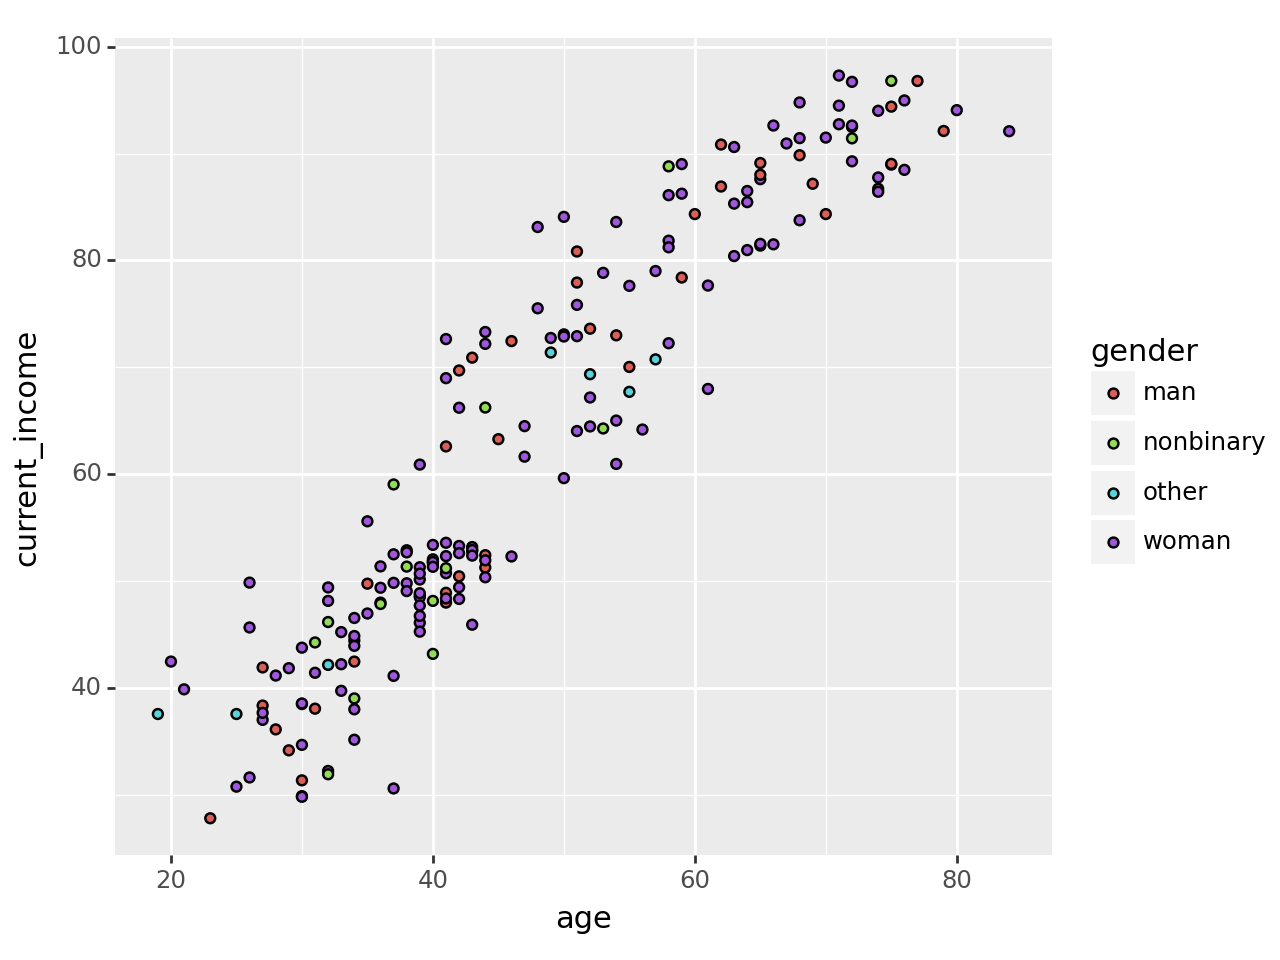

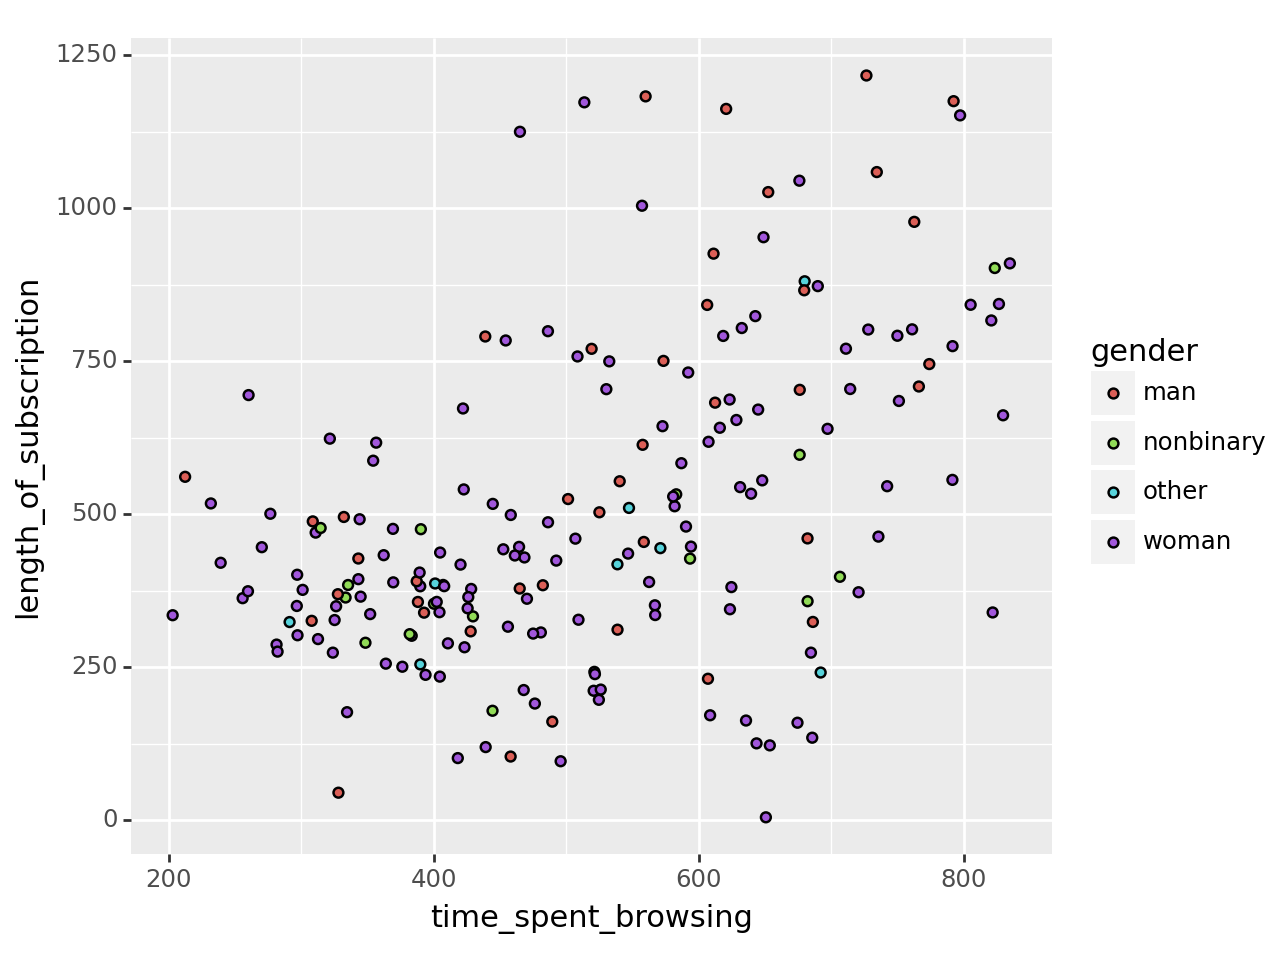

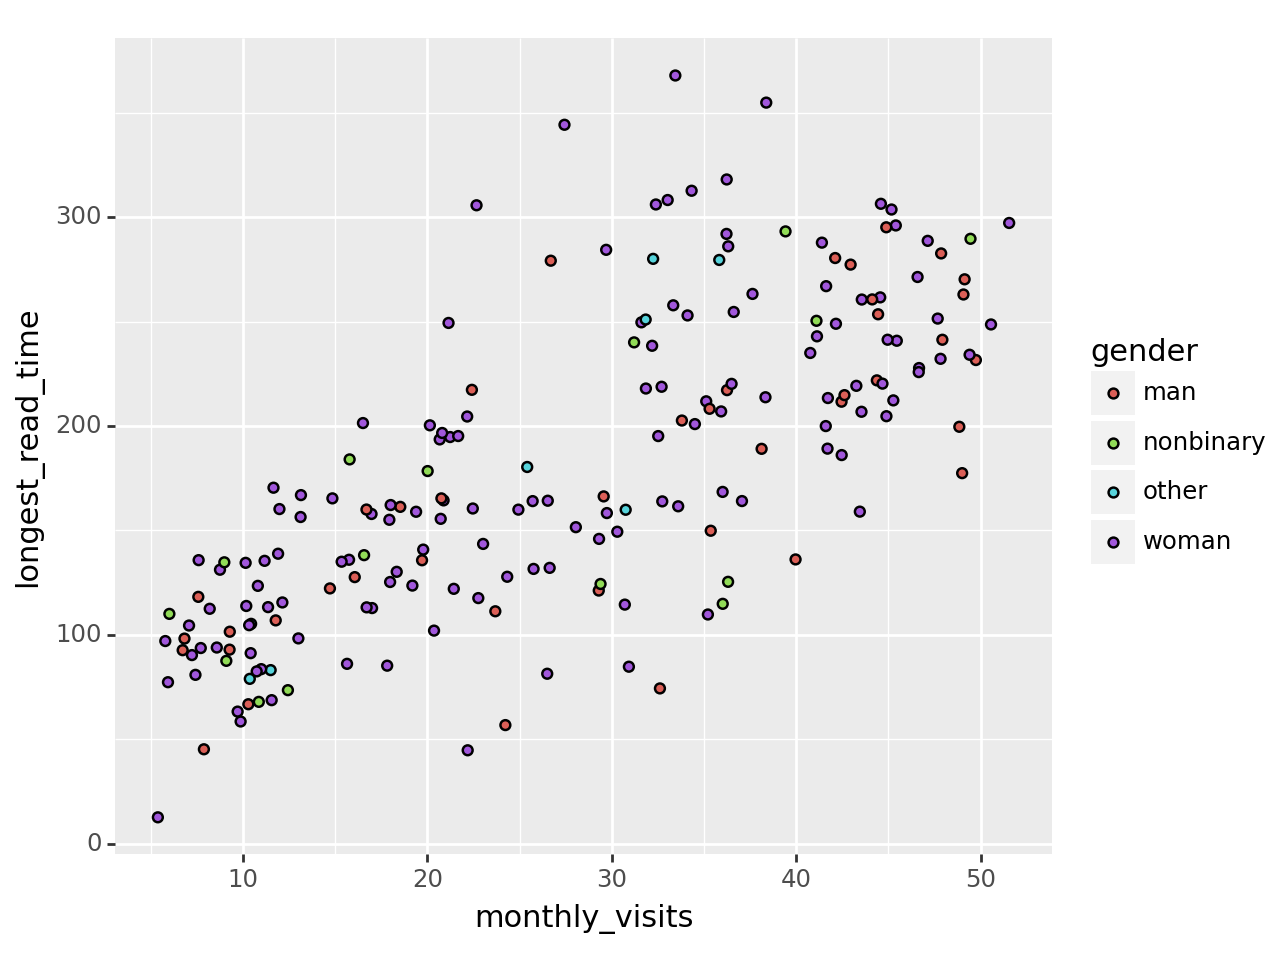

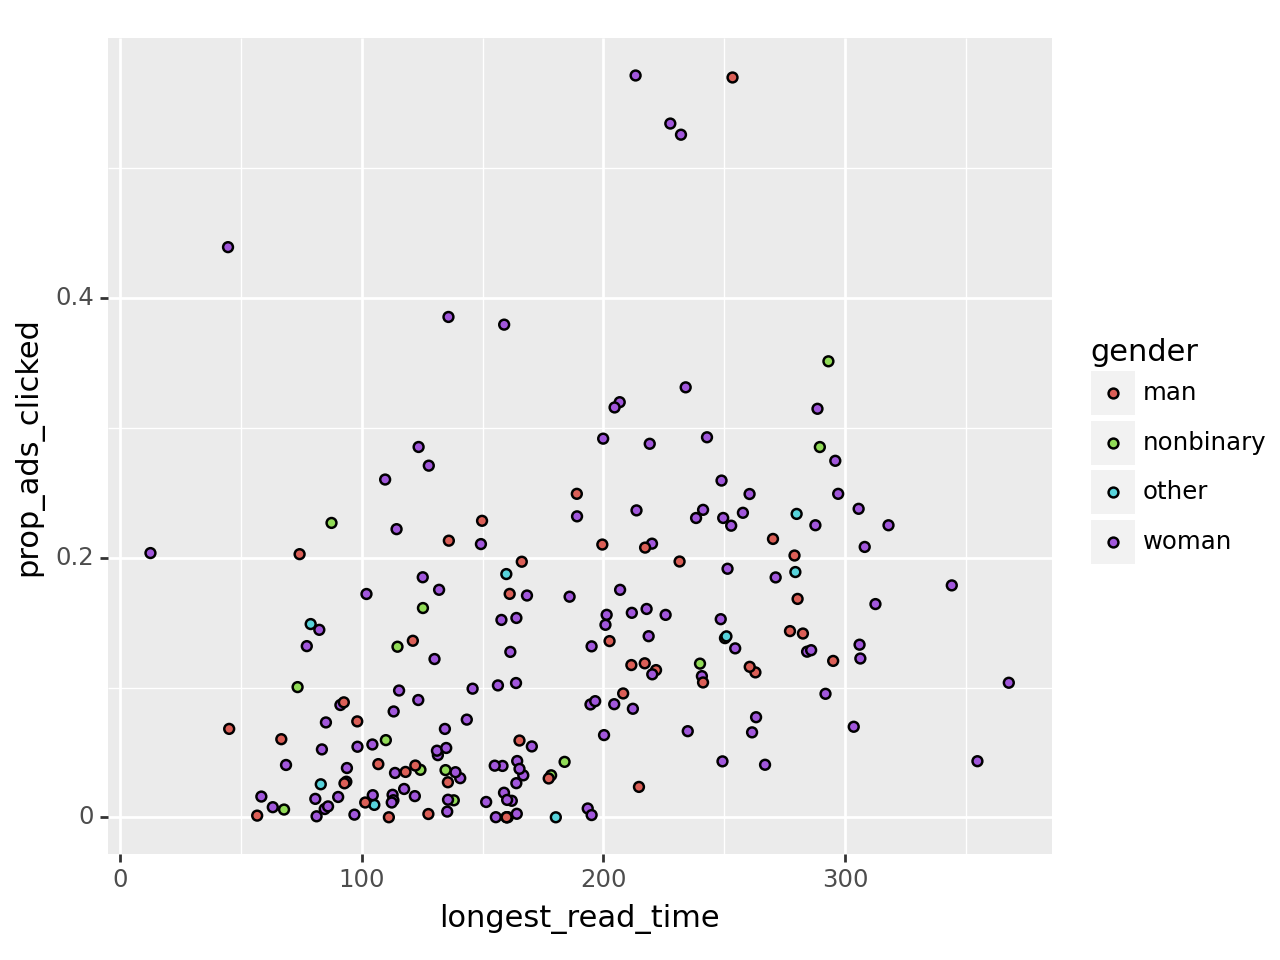

In [47]:
print((ggplot(behave, aes(x='age', y='current_income', fill='gender')) +
 geom_point()))

print((ggplot(behave, aes(x='time_spent_browsing', y='length_of_subscription', fill='gender')) +
 geom_point()))

print((ggplot(behave, aes(x='monthly_visits', y='longest_read_time', fill='gender')) +
 geom_point()))

print((ggplot(behave, aes(x='longest_read_time', y='prop_ads_clicked', fill='gender')) +
 geom_point()))

# Time Spent Browsing vs Length of Subscription: The data appears quite spread out. There are no clear, distinct groups that would indicate
# a good fit for K-Means, which looks for spherical clusters.

# Monthly Visits vs Longest Read Time: Similarly, this plot does not show clear clusters. Instead, there is a wide dispersion of data points.

# Proportion of Ads Clicked vs Longest Read Time: This plot shows some potential groupings or patterns but not clear spherical clusters.

# Given that none of the scatter plots suggest clear spherical clusters and that the data points are quite dispersed without clear boundaries,
# Gaussian Mixture Models (GMM) still seems like an appropriate choice. GMM can accommodate the overlap and doesn't assume the clusters
# to be of any specific shape, which seems to match the pattern in your data.

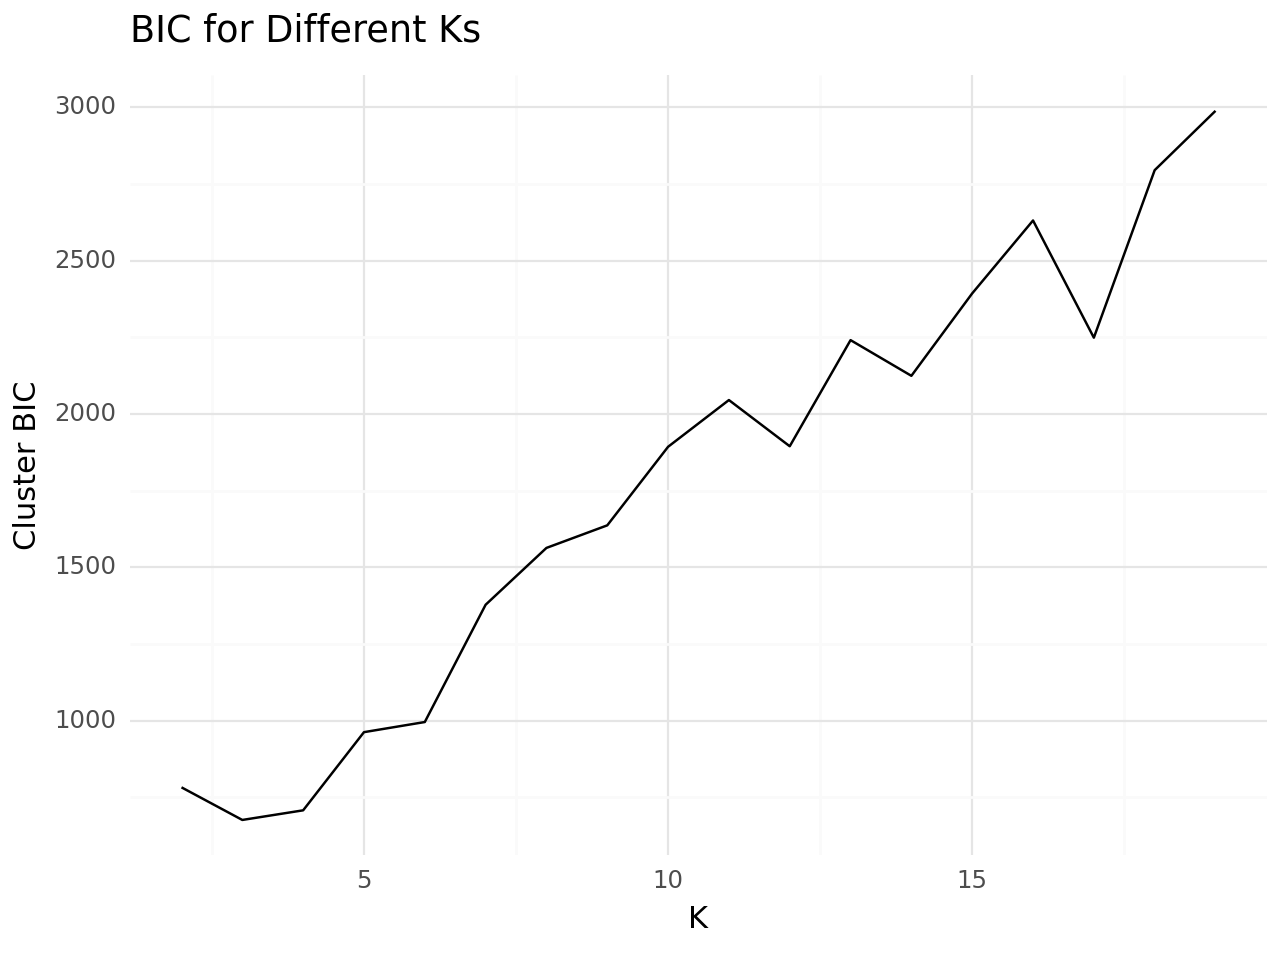

In [62]:
feats = [c for c in behave.columns if c not in ["id", "gender"]]

X = behave[feats]

# create empty model
z = make_column_transformer((StandardScaler(), feats),
                            remainder = "passthrough")

metrics = {"BIC": [], "k": []}

for i in range(2,20):
    gmm = GaussianMixture(i)
    pipe = Pipeline([
        ("pre", z),
        ("gmm", gmm)
    ])

    pipe.fit(X) # Fit the pipeline, which includes the GMM
    transformed_data = pipe.named_steps["pre"].transform(X) # Transform the data using the preprocessor
    bic_val = pipe.named_steps["gmm"].bic(transformed_data) # Calculate the BIC on the transformed data
    # labels = pipe.fit_predict(X[feats])
    # bic_val = pipe.named_steps["gmm"].bic(X[feats])

    metrics["BIC"].append(bic_val)
    metrics["k"].append(i)

df = pd.DataFrame(metrics)

print(ggplot(df, aes(x = "k", y = "BIC")) +
  geom_line() + theme_minimal() +
    labs(x = "K", y = "Cluster BIC",
         title = "BIC for Different Ks"))

# use n=3 based on graph



The average silhouette_score is : 0.1783031030655335


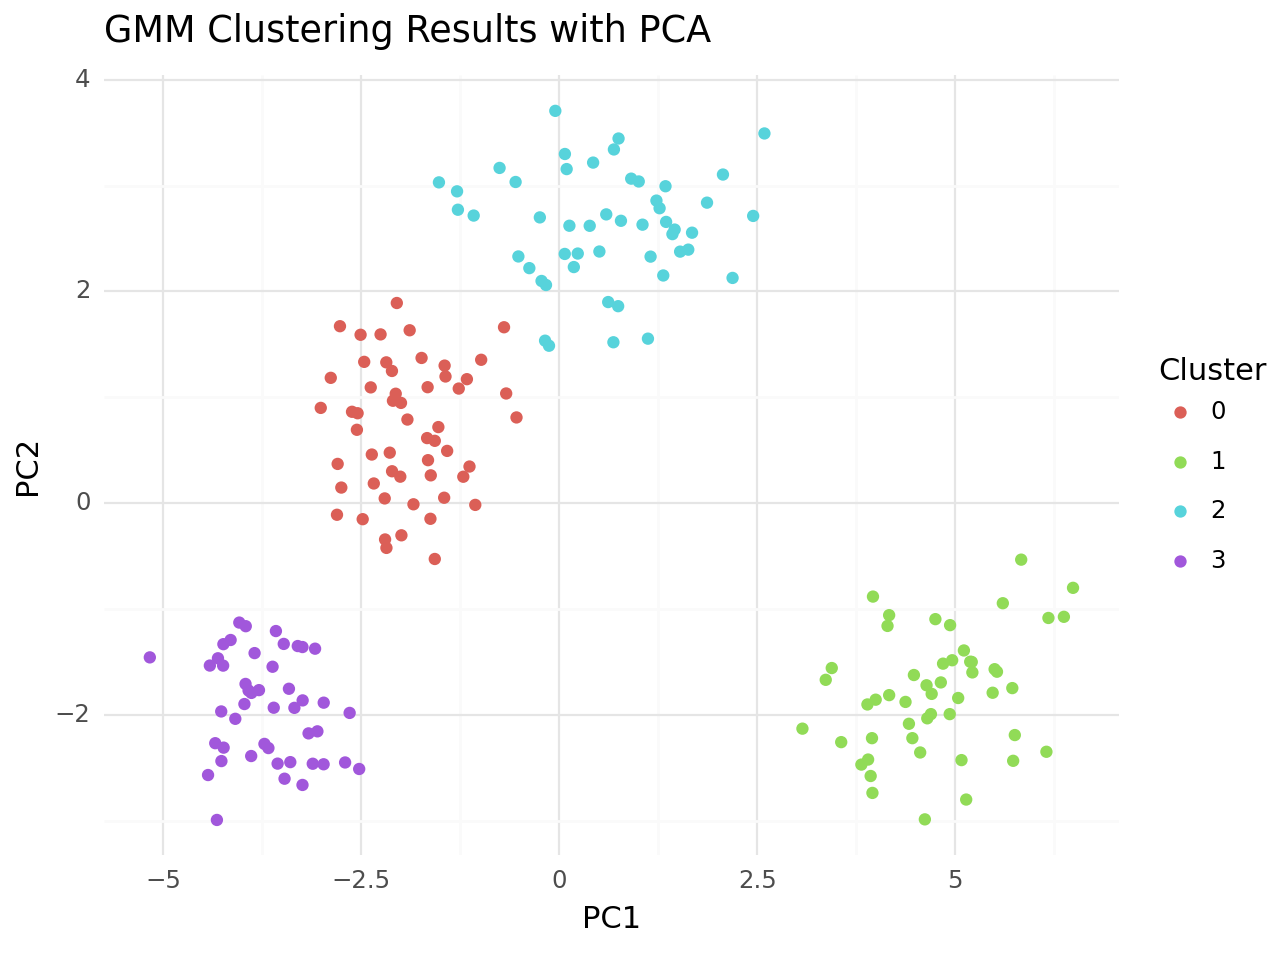

In [64]:
z = make_column_transformer((StandardScaler(), feats),
                            remainder = "passthrough")

pca = PCA(n_components = 2)

gmm = GaussianMixture(n_components = 4)

pipe_b = Pipeline([
    ("z", z),
    ("pca", pca),
    ("clust", gmm)])

# Fit the pipeline and predict the cluster labels
pipe_b.fit(X)
labels = pipe_b.named_steps['clust'].predict(pipe_b.named_steps['pca'].transform(pipe_b.named_steps['z'].transform(X)))

# Attach the cluster labels to your dataframe
X['clusters'] = labels

# Extract the PCA components
X['PC1'] = pipe_b.named_steps['pca'].transform(pipe_b.named_steps['z'].transform(X))[:, 0]
X['PC2'] = pipe_b.named_steps['pca'].transform(pipe_b.named_steps['z'].transform(X))[:, 1]

# Calculate the silhouette score
silhouette_avg = silhouette_score(X[feats], labels)
print("The average silhouette_score is :", silhouette_avg)

# Create the scatterplot using plotnine
plot = (ggplot(X, aes(x='PC1', y='PC2', color='factor(clusters)')) +
        geom_point() +
        theme_minimal() +
        labs(title='GMM Clustering Results with PCA', color='Cluster'))

print(plot)

In [70]:
# Group the data by clusters
cluster_groups = X.groupby('clusters')

# Calculate the mean for each feature within each cluster
cluster_summary = cluster_groups.mean()

# Calculate the size of each cluster
cluster_sizes = cluster_groups.size().to_frame(name='size')

# Combine the summary stats and sizes into a single DataFrame
summary_table = cluster_summary.join(cluster_sizes)

# Round the summary table to two decimal places
summary_table_rounded = summary_table.round(4)

# Convert the rounded summary table to string
summary_string = summary_table_rounded.to_string()

# Print the neatly formatted summary table
print(summary_string)


           level_0     index      age  current_income  time_spent_browsing  length_of_subscription  monthly_visits  longest_read_time  prop_ads_clicked     PC1     PC2  size
clusters                                                                                                                                                                     
0          77.1852   77.1852  39.7778         50.0846             392.2197                385.9628         20.6939           149.4159            0.0716 -1.9190  0.6976    54
1         174.5000  174.5000  68.6600         89.0994             671.9755                812.0288         44.8070           247.7983            0.2114  4.7682 -1.7880    50
2          24.5000   24.5000  50.4800         71.3882             611.5321                449.3457         33.4450           215.7775            0.1719  0.5844  2.6055    50
3         125.6957  125.6957  30.0435         39.4739             379.0441                344.9800          9.8045            98.2

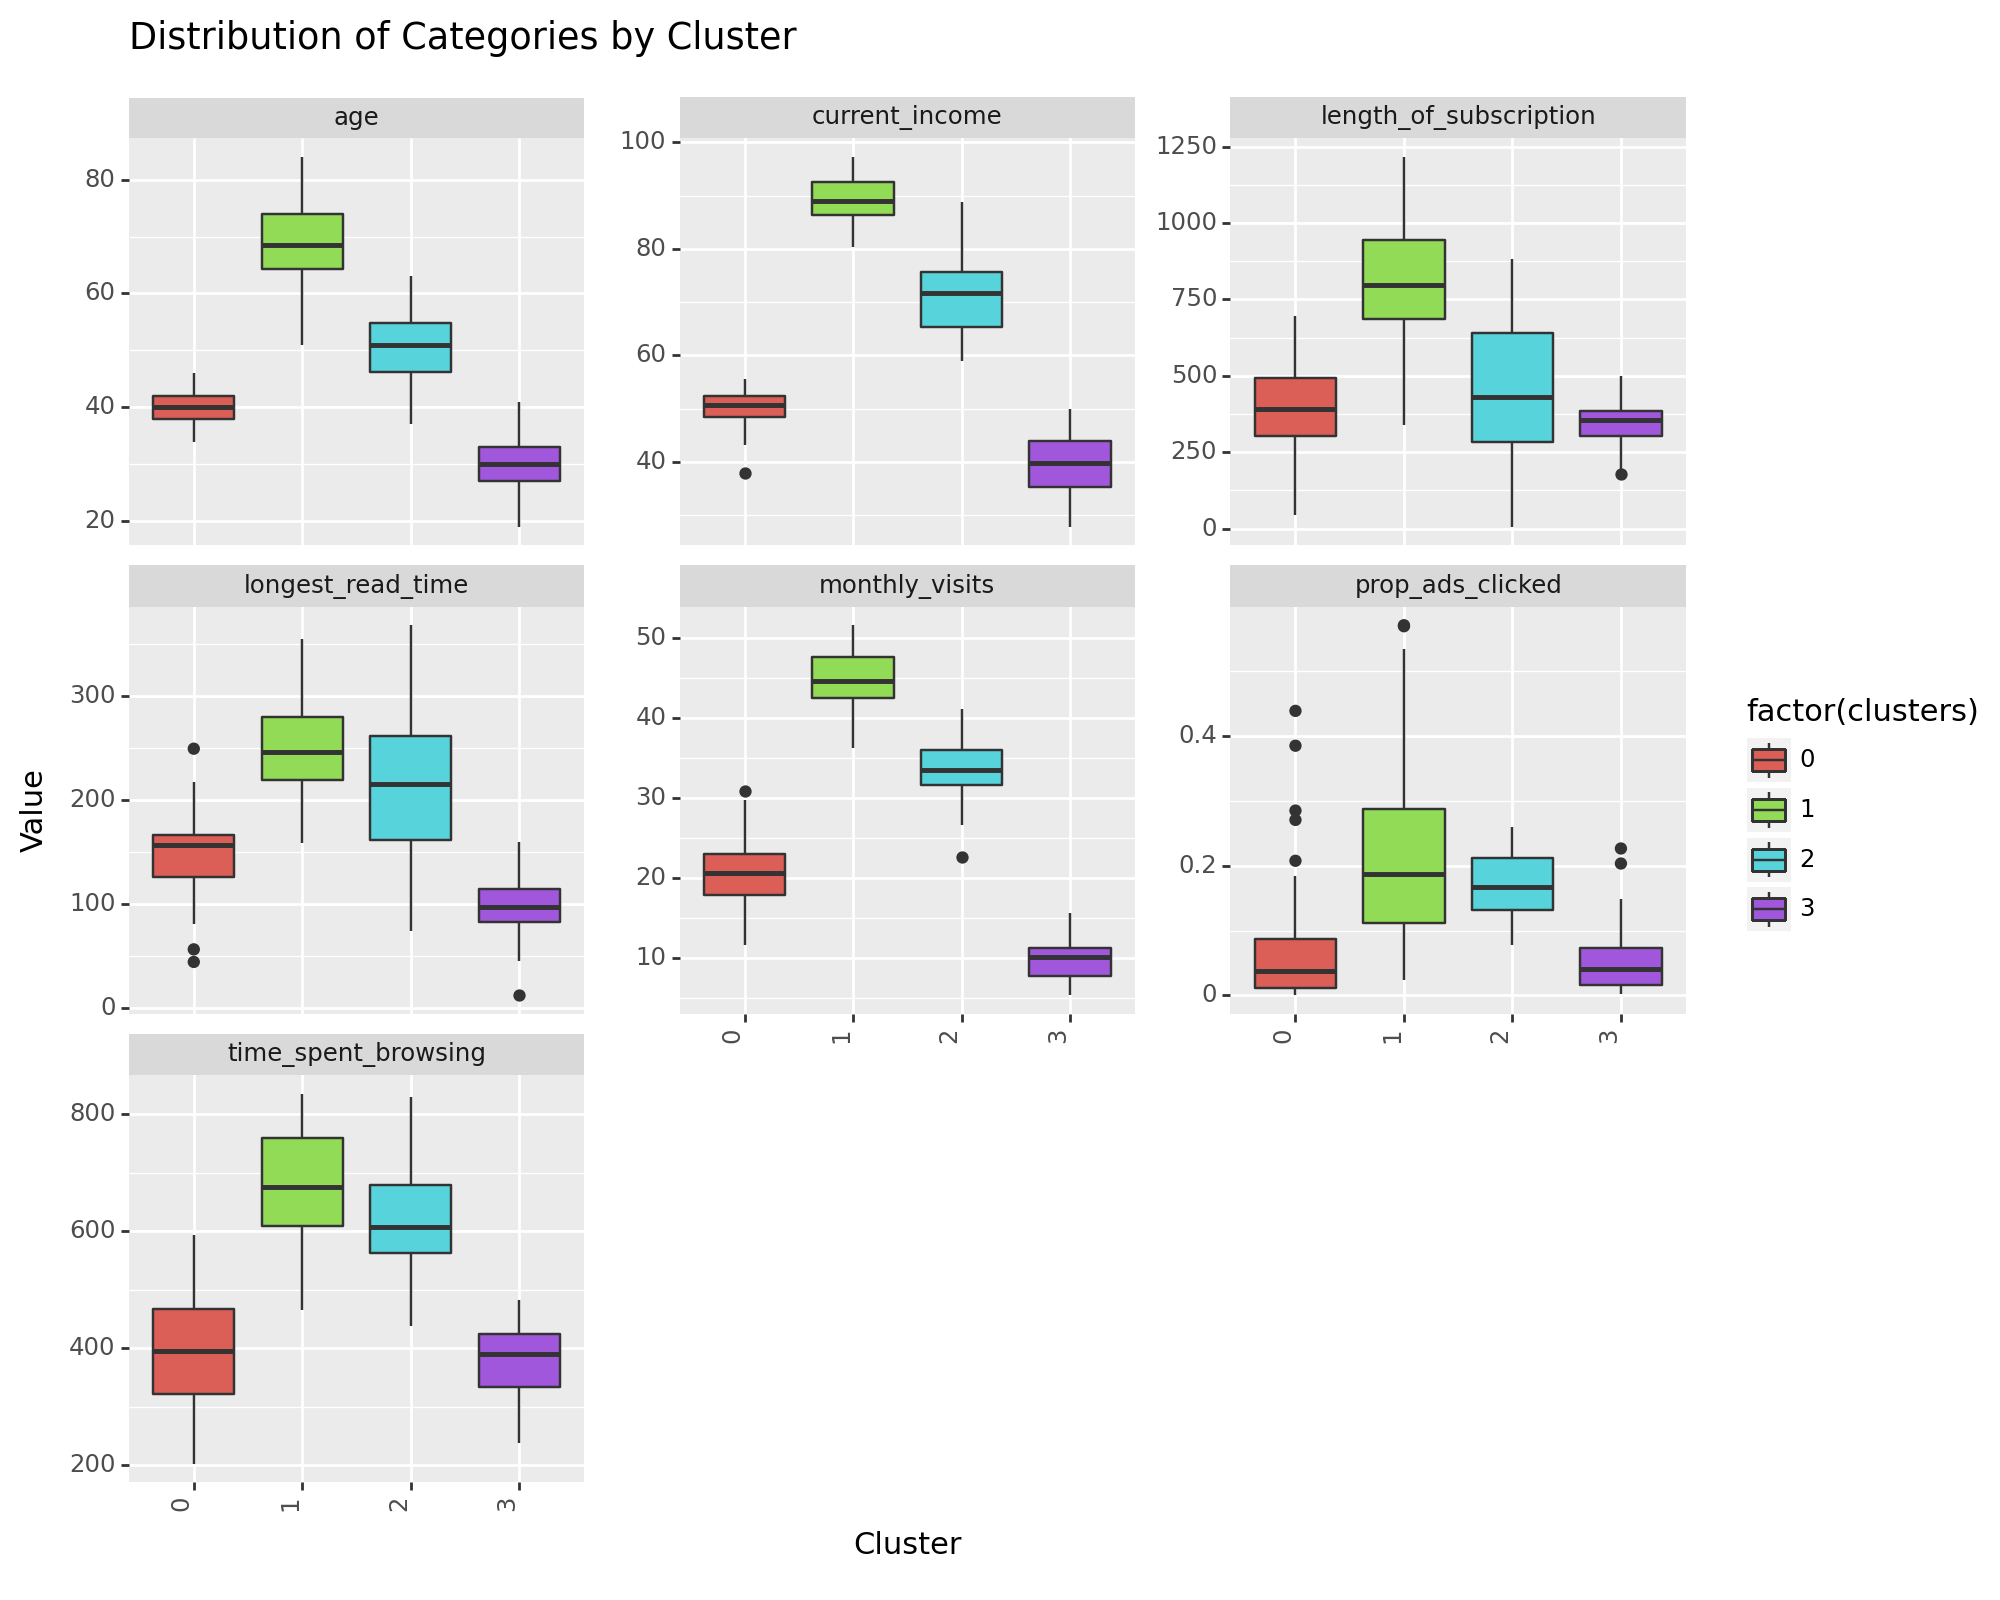

In [124]:
X.columns

# Melt the DataFrame to long format for faceting in ggplot
melted_data = X.melt(id_vars='clusters', var_name='Category', value_name='Value')

melted_data = melted_data[~melted_data['Category'].isin(['clusters', 'PC1', 'PC2', 'index', 'level_0'])]


# Create the boxplot with facets for each category, colored by cluster
boxplot = (ggplot(melted_data, aes(x='factor(clusters)', y='Value', fill='factor(clusters)')) +
           geom_boxplot() +
           facet_wrap('~Category', scales='free_y') +  # 'scales' can also be 'fixed' depending on your preference
           theme(axis_text_x=element_text(rotation=90, hjust=1),  # Rotate the x labels for readability
                 figure_size=(10, 8)) +  # Adjust figure size as needed
           labs(title='Distribution of Categories by Cluster', x='Cluster', y='Value'))

# Display the plot
print(boxplot)


## 2. Article Clustering
- Using an `sklearn` `Pipeline`, build and fit a **Hierarchical Clustering** model using all the variables *except* `id`. Use cosine similarity as your distance metric (also called `affinity`) and `average` linkage.
- Do **not** z-score, as these are counts.
- Create a dendrogram and in the **Methods** section of your report, explain **what number** of cluster you decided to use and **why**.
- In the **Results** section, discuss the performance of the model based on the dendrogram.
- Create at least one other summary of what kind of customers are in each cluster. This could be a different ggplot (built using plotnine), or a neatly formatted summary table (hint: `groupby()`). In the **Results** section, discuss in detail what kind of customers are in each cluster, and how that information might help the company.


In [78]:
article = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/HW3_topics.csv")
article.head()

,Stocks,Productivity,Fashion,Celebrity,Cryptocurrency,Science,Technology,SelfHelp,Fitness,AI,id
0,3,12,9,9,1,1,5,1,0,1,84
1,1,0,1,1,0,8,4,10,4,0,59
2,4,1,11,1,6,11,0,9,0,0,161
3,2,6,8,1,15,1,1,9,8,0,40
4,1,2,4,4,6,6,2,1,3,4,98


In [81]:
# from sklearn: https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
def plot_dendrogram(pipe, **kwargs):

    if "model" not in pipe.named_steps.keys():
        raise NameError("Your clustering pipeline step must be called 'model' for this function to work.")

    # create the counts of samples under each node
    counts = np.zeros(pipe.named_steps["model"].children_.shape[0])
    n_samples = len(pipe.named_steps["model"].labels_)
    for i, merge in enumerate(pipe.named_steps["model"].children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [pipe.named_steps["model"].children_, pipe.named_steps["model"].distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    sch.dendrogram(linkage_matrix, **kwargs)

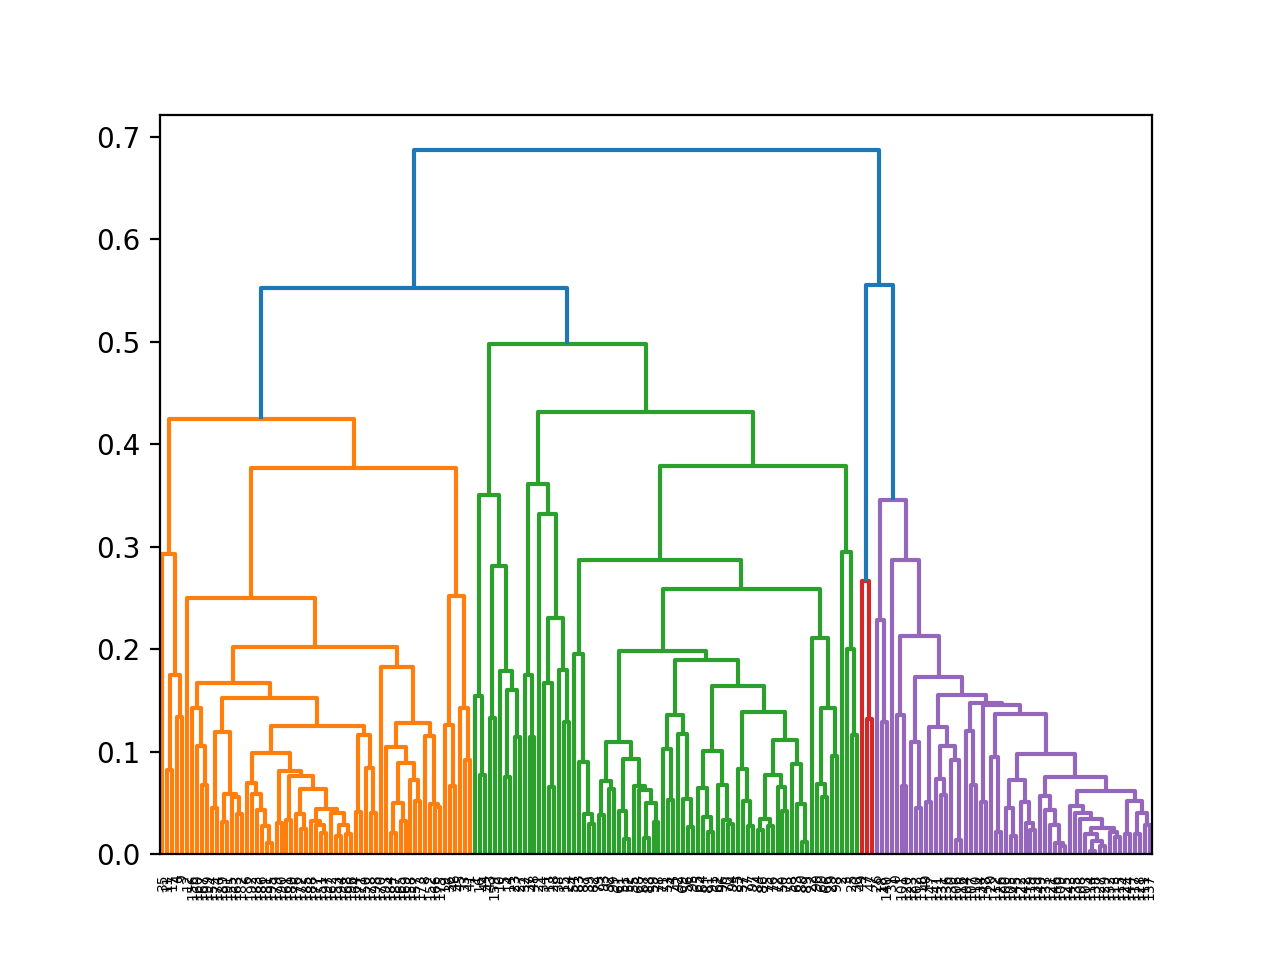

In [113]:
feats_art = [c for c in article.columns if c != "id"]

X_art = article[feats_art]

hac = AgglomerativeClustering(affinity = "cosine",
                             linkage = "average",
                             distance_threshold=0,
                             n_clusters = None) # come back and change the number of clusters

pipe = Pipeline([("model", hac)])


# fit model and get labels
labels = pipe.fit_predict(X_art[feats_art])

plot_dendrogram(pipe, color_threshold = 0.5)

In [116]:
# re-fit empty model with num clusters
hac = AgglomerativeClustering(affinity = "cosine",
                             linkage = "average",
                             n_clusters = 4) # come back and change the number of clusters

pipe2 = Pipeline([("model", hac)])


# fit model and get labels
labels = pipe2.fit_predict(X_art[feats_art])

# look at cluster performance
print(silhouette_score(X_art[feats_art], labels))

0.14884793072334204


In [115]:
X_art.columns

Index(['Stocks', 'Productivity', 'Fashion', 'Celebrity', 'Cryptocurrency',
       'Science', 'Technology', 'SelfHelp', 'Fitness', 'AI'],
      dtype='object')

In [117]:
# Add the cluster labels to your DataFrame
X_art['clusters'] = labels

# Group the data by clusters
cluster_groups = X_art.groupby('clusters')

# Calculate the mean for each feature within each cluster
cluster_summary = cluster_groups.mean()

# Calculate the size of each cluster
cluster_sizes = cluster_groups.size().to_frame(name='size')

# Combine the summary stats and sizes into a single DataFrame
summary_table = cluster_summary.join(cluster_sizes)

# Round the summary table to two decimal places
summary_table_rounded = summary_table.round(4)

# Convert the rounded summary table to string
summary_string = summary_table_rounded.to_string()

# Print the neatly formatted summary table
print(summary_string)

          Stocks  Productivity  Fashion  Celebrity  Cryptocurrency  Science  Technology  SelfHelp  Fitness       AI  size
clusters                                                                                                                 
0         8.5385       10.0769   2.8333     0.8205          2.3462   4.2436      2.4615   13.6282   7.1795   7.2692    78
1         4.2540        3.8889   3.6825     3.5397          5.0635  15.9841     19.9206    2.8095   3.7302  24.2063    63
2         5.0000        5.0000   1.0000     5.3333         12.6667   1.0000      3.3333    1.6667   1.0000   1.3333     3
3         1.9107        2.7679  12.6071    17.2500          1.5179   2.0000      2.5179    2.8929   1.6071   1.9286    56


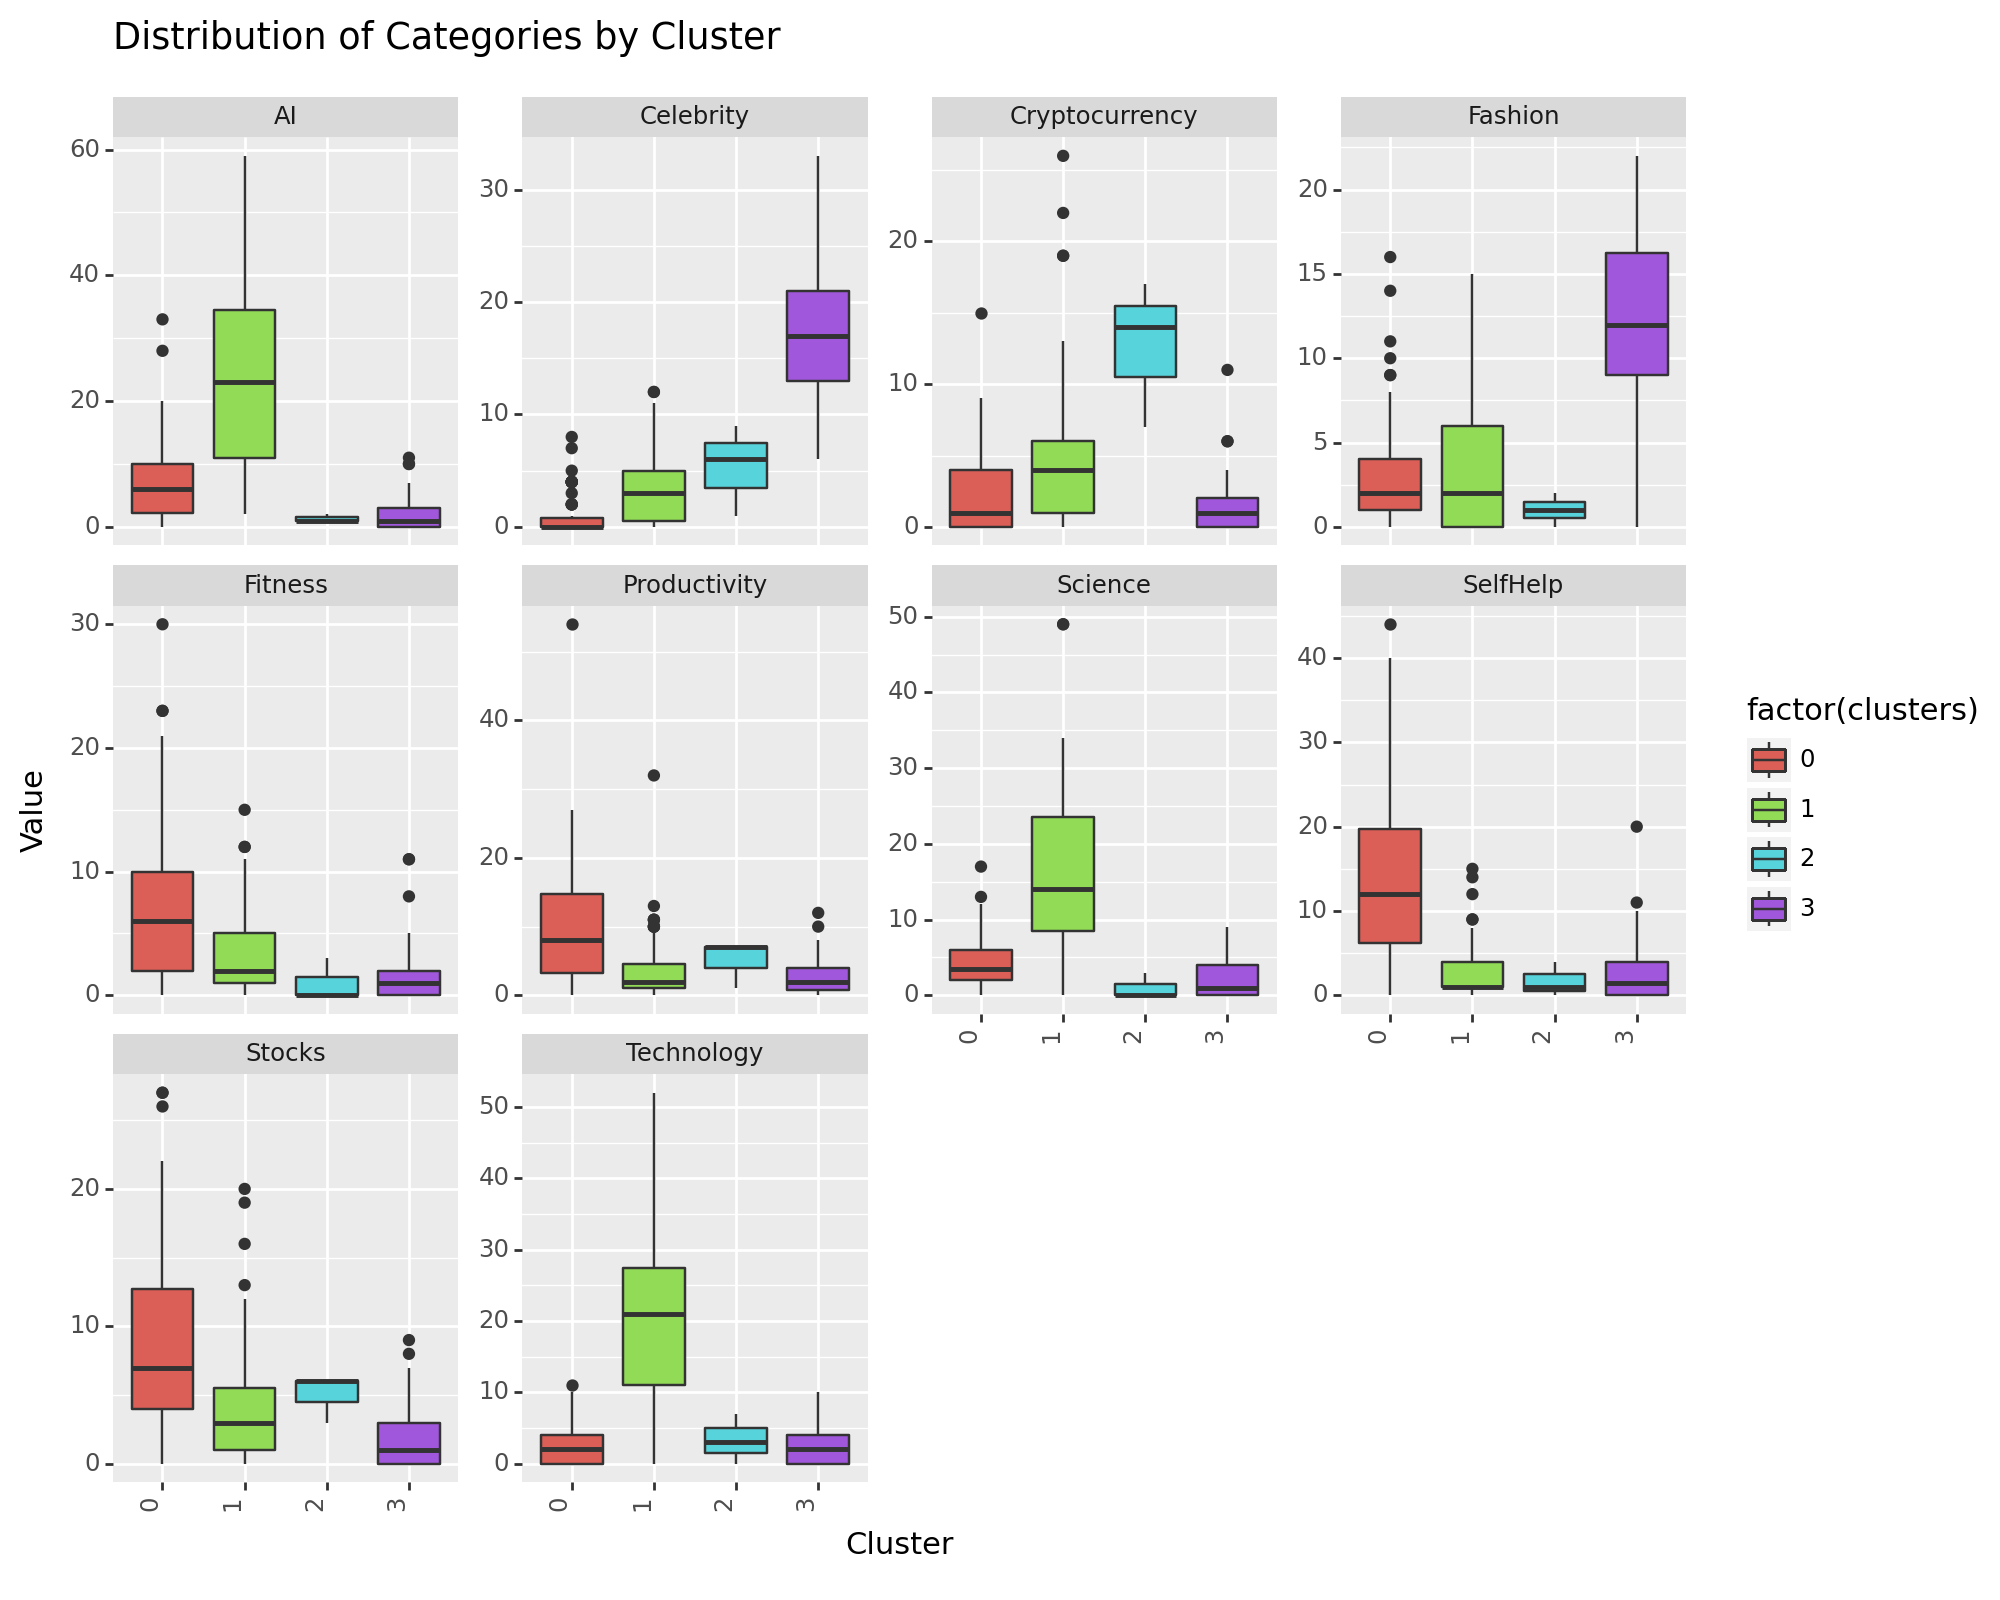

In [119]:
X_art.columns

# Melt the DataFrame to long format for faceting in ggplot
melted_data = X_art.melt(id_vars='clusters', var_name='Category', value_name='Value')

# Exclude 'clusters' column from the categories to be faceted
melted_data = melted_data[melted_data['Category'] != 'clusters']

# Create the boxplot with facets for each category, colored by cluster
boxplot = (ggplot(melted_data, aes(x='factor(clusters)', y='Value', fill='factor(clusters)')) +
           geom_boxplot() +
           facet_wrap('~Category', scales='free_y') +  # 'scales' can also be 'fixed' depending on your preference
           theme(axis_text_x=element_text(rotation=90, hjust=1),  # Rotate the x labels for readability
                 figure_size=(10, 8)) +  # Adjust figure size as needed
           labs(title='Distribution of Categories by Cluster', x='Cluster', y='Value'))

# Display the plot
print(boxplot)


## 3. Report

[QUARTO TEMPLATE HERE](https://github.com/cmparlettpelleriti/CPSC392ParlettPelleriti/blob/master/Homework/Homework3Template.qmd)

[DOCS TEMPLATE HERE](https://docs.google.com/document/d/1ZxUz6WPFjadOh4tkZS0ydkFFXfXQytNf34-Cgx_eap4/edit?usp=sharing)

Your Technical Report is a way to practice presenting and formatting your results like you would in industry. Make sure your report and **plots** are clear, and explain things clearly. Write a report that has the following sections:

1. **Introduction**: description of the problem (e.g. what are you predicting? what variables do you have available? How might this model be useful if you are successful). You should end with a sentence or two about what the impact of these models could be.

2. **Methods**: describe your models in detail (as if explaining them to the CEO of the media company), as well as any pre-processing you had to do to the data.

3. **Results**: How did your models perform? Describe the clusters from your Behavioral Clustering models. Were they different? If so, how? What could the CEO of the media company do with these clusters? Describe the clusters form your Article Clustering model. What could the CEO of the media company do with these clusters?

4. **Discussion/Reflection**: A few sentences about what you learned from performing these analyses, and at least one suggestion for what you'd add or do differently if you were to perform this analysis again in the future.